# Подход 1: градиентный бустинг "в лоб"

Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

## Шаг 1: считать таблицу с признаками

In [67]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

train = pd.read_csv('features.csv', index_col='match_id')
test = pd.read_csv('features_test.csv',index_col='match_id')

# Удаление признаков, связанных с итогами матча
train.drop(['duration','tower_status_radiant','tower_status_dire','barracks_status_radiant','barracks_status_dire'],axis=1,inplace=True)

#целевая переменная
y_train = train['radiant_win']

del train['radiant_win']

# нахождение пропусков
for i in list(train):
    if train[i].isnull().sum() > 0:
        print(f"{i}: {train[i].isnull().sum()} пропусков")

# заполнение пропусков нулями
x_train = train.fillna(0)
x_test = test.fillna(0)

first_blood_time: 19553 пропусков
first_blood_team: 19553 пропусков
first_blood_player1: 19553 пропусков
first_blood_player2: 43987 пропусков
radiant_bottle_time: 15691 пропусков
radiant_courier_time: 692 пропусков
radiant_flying_courier_time: 27479 пропусков
radiant_first_ward_time: 1836 пропусков
dire_bottle_time: 16143 пропусков
dire_courier_time: 676 пропусков
dire_flying_courier_time: 26098 пропусков
dire_first_ward_time: 1826 пропусков


**Пропуски имеют**:
- информация о первой крови (в течение 5 минут игры не происходит первая кровь):
    - время;
    - команда, совершившая первую кровь;
    - игрок 1;
    - игрок 2;
- время покупки предметов (игроки не покупают предметы):
    - время покупки предмета bottle командой Radiant;
    - время покупки предмета courier командой Radiant;
    - время покупки предмета flying courier командой Radiant;
    - время покупки предмета bottle командой Dire;
    - время покупки предмета courier командой Dire;
    - время покупки предмета flying courier командой Dire;
- время установки наблюдателя (игроки не устанавливают наблюдателей):
    - время установки командой Radiant первого "наблюдателя";
    - время установки командой Dire первого "наблюдателя"

**Целевая переменная**: radiant_win (исход матча: 1 - победа Radiant, 0 - победа Dire)

## Шаг 2: подобрать количество деревьев для модели

In [14]:
import datetime
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

cv = KFold(n_splits=5,shuffle=True,random_state=42)
scores = []
trees = [10,15,30,50,100,200]

for n in trees:
    model  = GradientBoostingClassifier(n_estimators=n,random_state=42)
    start = datetime.datetime.now()
    score = cross_val_score(model,x_train,y_train,cv=cv,scoring='roc_auc')
    print(f"{n} деревьев: затрачено {datetime.datetime.now() - start}, показатель AUC-ROC: {round(np.mean(score),3)}")
    scores.append(round(np.mean(score),3))

10 деревьев: затрачено 0:00:30.541657, показатель AUC-ROC: 0.665
15 деревьев: затрачено 0:00:44.821942, показатель AUC-ROC: 0.676
30 деревьев: затрачено 0:01:28.413156, показатель AUC-ROC: 0.69
50 деревьев: затрачено 0:02:29.616339, показатель AUC-ROC: 0.697
100 деревьев: затрачено 0:04:55.918992, показатель AUC-ROC: 0.706
200 деревьев: затрачено 0:09:51.659150, показатель AUC-ROC: 0.714


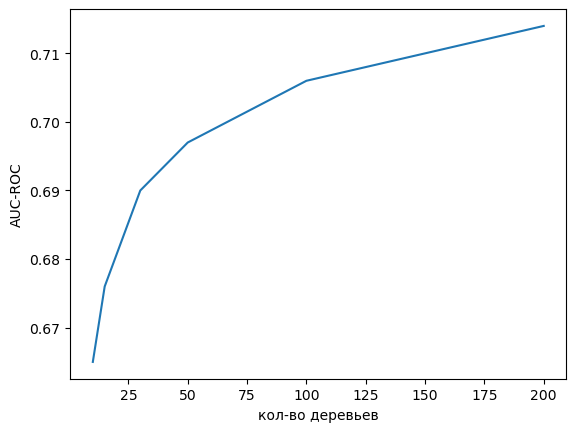

In [16]:
import matplotlib.pyplot as plt
plt.plot(trees,scores)
plt.xlabel('кол-во деревьев')
plt.ylabel('AUC-ROC')

plt.show()

При увеличении количества деревьев увеличивается показатель метрики AUC-ROС. Наиболее оптимальным количеством деревьем является 100 деревьев: при дальнейшем увеличении количества деревьев временные затраты перестают соответствовать увеличению показателю метрики AUC-ROC.

# Подход 2: логистическая регрессия
Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.
## Шаг 1: загрузка данных

In [68]:
x_scaled = StandardScaler().fit_transform(train.fillna(0))

# Шаг 2: подбор C (параметра регуляризации)

In [71]:
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5, shuffle=True, random_state=1)
C = [1e-7, 1e-4, 1e-3, 1]
def score_roc_auc(x):
    for i in C:
        logit = LogisticRegression(C=i, random_state=1, penalty='l2')
        start = datetime.datetime.now()
        score = cross_val_score(logit, x, y_train, scoring='roc_auc', cv=kf)
        print(f"C={i}: качество: {round(score.mean(),3)}, затраченное время: {datetime.datetime.now() - start}")
score_roc_auc(x_scaled)

C=1e-07: качество: 0.687, затраченное время: 0:00:01.012087
C=0.0001: качество: 0.711, затраченное время: 0:00:01.232378
C=0.001: качество: 0.716, затраченное время: 0:00:02.175142
C=1: качество: 0.716, затраченное время: 0:00:03.140787


Качество у логистической регрессии над всеми исходными признаками получилось равным 0.716. Примерно такое же качество возможно при использовании 200 деревьев при градиентном бустинге "в лоб". Однако затраты по времени при использовании логистической регрессии ничтожно малы по сравнению с градиентным бустингом.

Уберём категориальные признаки:

In [83]:
# удаление категориальных признаков
x_clean = x_train.drop(['lobby_type','r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero','d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero','first_blood_player1', 'first_blood_player2'], axis=1)
x_clean_scaled = StandardScaler().fit_transform(x_clean)
score_roc_auc(x_clean)

C=1e-07: качество: 0.513, затраченное время: 0:00:01.021116
C=0.0001: качество: 0.513, затраченное время: 0:00:00.999631
C=0.001: качество: 0.513, затраченное время: 0:00:01.071809
C=1: качество: 0.513, затраченное время: 0:00:01.070044


Качество изменилось при малом параметре регуляризации C, но в целом увеличение качества ничтожно мало.

Определим количество героев:

In [77]:
heroes = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
        'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
unique = np.array([])
for hero in heroes:
    unique = np.append(unique,pd.unique(x_train[hero]))
print(f"Всего {np.shape(pd.value_counts(unique))[0]} идентификаторов героев")

Всего 108 идентификаторов героев


Добавим "мешок слов" по героям:

In [87]:
hero_c = [c for c in x_train.columns if 'hero' in c]
heroes_ids = np.unique(x_train[hero_c])

word_bucket = {}
for id in heroes_ids:
    r = [(x_train['r%d_hero' % n] == id) for n in range(1, 6)]
    d = [(x_train['d%d_hero' % n] == id) for n in range(1, 6)]
    word_bucket['hero%s' % id] = sum(r) - sum(d)
x_bucket = x_clean.assign(**word_bucket)
x_bucket_scaled = StandardScaler().fit_transform(x_bucket)

score_roc_auc(x_bucket_scaled)

C=1e-07: качество: 0.706, затраченное время: 0:00:01.417933
C=0.0001: качество: 0.743, затраченное время: 0:00:01.638844
C=0.001: качество: 0.752, затраченное время: 0:00:02.804161
C=1: качество: 0.752, затраченное время: 0:00:04.675023


Качество увеличилось до 0.752, так как используется больше информации о героях.

## Шаг 3: построениее предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей

In [89]:
C = 0.001
logit = LogisticRegression(C=C, random_state=1, penalty='l2')
logit.fit(x_bucket_scaled,y_train)
x_test_clean = x_test.drop(['lobby_type','r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero','d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero','first_blood_player1', 'first_blood_player2'], axis=1)
hero_c = [c for c in x_test.columns if 'hero' in c]
heroes_ids = np.unique(x_test[hero_c])

word_bucket = {}
for id in heroes_ids:
    r = [(x_test['r%d_hero' % n] == id) for n in range(1, 6)]
    d = [(x_test['d%d_hero' % n] == id) for n in range(1, 6)]
    word_bucket['hero%s' % id] = sum(r) - sum(d)
x_test_bucket = x_test_clean.assign(**word_bucket)
x_test_bucket_scaled = StandardScaler().fit_transform(x_test_bucket)

pred = logit.predict_proba(x_test_bucket_scaled)[:, 1]
print(f"Минимальное значение прогноза: {pred.min()}")
print(f"Максимальное значение прогноза: {pred.max()}")

Минимальное значение прогноза: 0.009845169960294841
Максимальное значение прогноза: 0.9948514209566268
